# HOMEWORK 6

In this homework you are going to use the Harris corner detector to detect the corners of a document. Document detection is a crucial task for many applications, e.g., text recognition, automatic passport reading (at airport gates), etc.

You will also have to design your own feature descriptor in order to localize and distinguish among the 4 document corners.

At the end of this notebook, there are a couple of questions for you to answer.

So let's begin, shall we?

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image we will be working on in this homework.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2463d4d4820>)

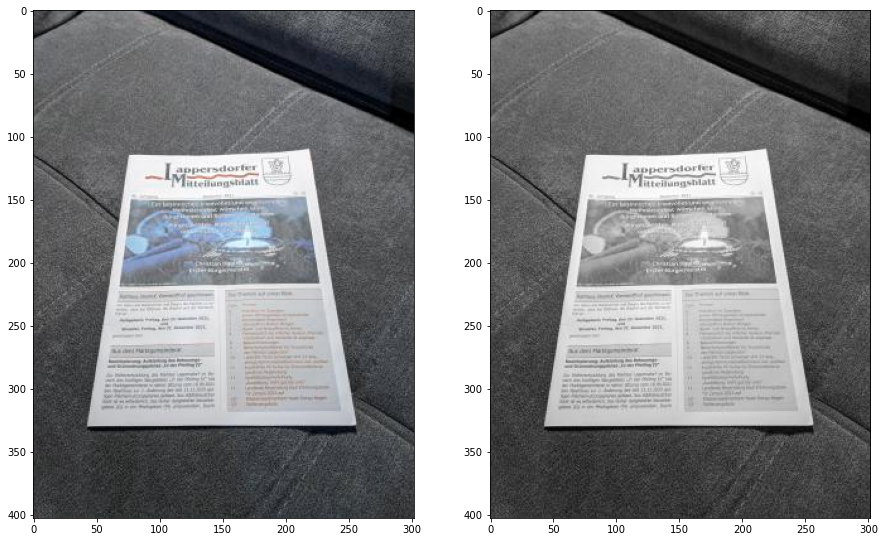

In [2]:
# Let's read the image
img = cv2.imread('./data/document.jpg')
# Convert it to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

### Harris Corner Detector
Let us now compute Harris corners. Remember that the Harris detector computes the "cornerness" score for each image pixel.

In [3]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04
cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# We are not interested in edges, so put to zero all negative cornerness values
rows, cols = cornerness.shape
th = 0.3 * np.max(cornerness)

for r in range(rows):
    for c in range(cols):
        if cornerness[r, c] < th:
            cornerness[r, c] = 0

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x24641b4a0a0>)

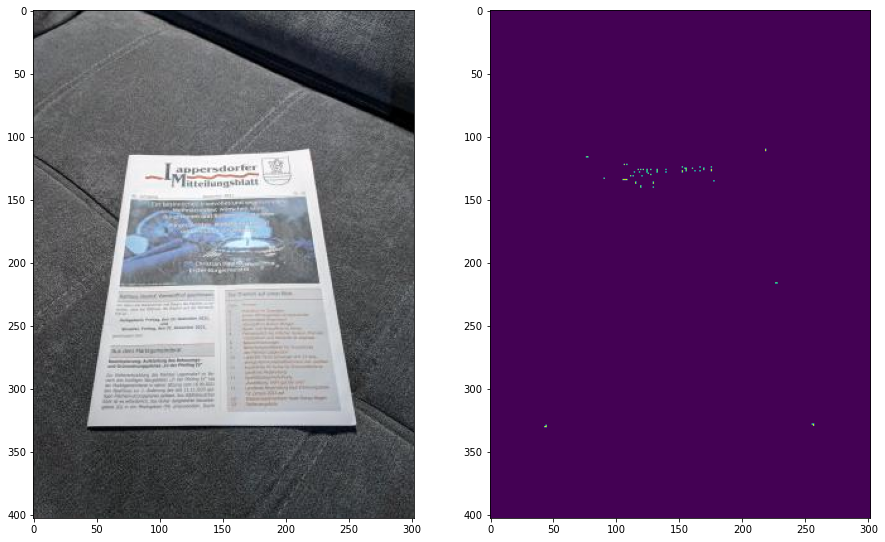

In [4]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

At this point, you can see that the Harris detector has detected a lot of features. Not only the four document corners, but also the corners corresponding to (black) letters printed on (white) paper. How can we filter out everything but the 4 document corners?

For that purpose, let's design a custom feature descriptor suitable to detect the document corners. In order to do so, let's have a look at the top left corner.

![Top-left corner](../data/document_descriptor_example.jpg "Top-left corner")

A good descriptor of that corner, given a certain neghbouring region, would be to assess that the bottom-right quadrant is (much) brighter than the other three quadrants (i.e. top-left, top-right, bottom-left). Let's then implement it :-) I'll do the implementation for the top-left corner, you shall do the rest.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x24640400c70>)

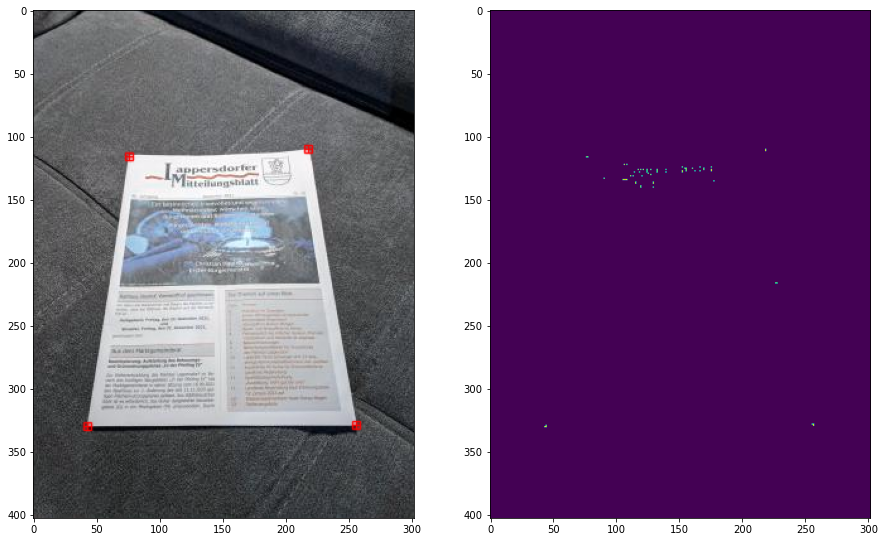

In [5]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_ritgh = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[quad_size:quad_size * 2 + 1, 0:quad_size]
        quad_bottom_left = block[0:quad_size, quad_size:quad_size * 2 + 1]
        quad_bottom_right = block[quad_size:quad_size * 2 + 1, quad_size:quad_size * 2 + 1]
        
        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants

        descriptor = np.mean(quad_bottom_right) - np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)
            
        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - np.mean(quad_top_left) - np.mean(quad_bottom_right) - np.mean(quad_top_right)
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)
            
        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - np.mean(quad_top_left) - np.mean(quad_bottom_right) - np.mean(quad_bottom_left)
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)
            
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - np.mean(quad_bottom_right) - np.mean(quad_bottom_left) - np.mean(quad_top_right)
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

def draw_marker(img, coordinates):
    # img = cv2.circle(img, coordinates, 1, (255,0,0), -1)
    out = cv2.drawMarker(img, coordinates, (255,0,0), cv2.MARKER_SQUARE, quad_size, 1, cv2.LINE_AA)
    out = cv2.drawMarker(img, coordinates, (255,0,0), cv2.MARKER_CROSS, quad_size, 1, cv2.LINE_AA)
    return img
            
out = cv2.imread('./data/document.jpg')
            
# Let's draw circles at the detected corners
out = draw_marker(out, opt_top_left)
out = draw_marker(out, opt_top_right)
out = draw_marker(out, opt_bottom_left)
out = draw_marker(out, opt_bottom_right)

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)

### Questions
* Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?

`Sure. The 12Mpx camera gets more information about corners, because there is less smoothness around the adges`

* If we increased the resolution of the camera, what would you change in the current algorithm?

`Hm.. I think we could try to decrease some parameters a little bit, beacuse of less smoothnes. For example: quad_size in the last block, or gradient kernel size in the block where we use Corner Harris method`

Remember, I am **not** looking for a particular answer. I want to see how you think, so be creative ;-)